# Here we make a Random Forest Model For Nanoeukaryotes


In [20]:
# Running model preperation notebook that has a function we need to call
%run /Users/cristianswift/Desktop/armbrust-lab/Seaflow-Machine-Learning/python/04_Populations-model-fitting/01_model-preparation.ipynb


In [21]:
#loading packages for random forest modeling

from sklearn.model_selection import train_test_split
import joblib

## RF Regressor for Nanoeukaryotes

In [22]:
# creating a df, labels and features with only for the observed Nanoeukaryotes
population_name = 'nanoeukaryotes (2-5µm)'

pop_df, labels, features, feature_list = preprocess_single_population(covari, population_name)

In [23]:
# Using Skicit-learn to split data into training and testing sets
# Split the data into training and testing sets"
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.75, random_state = 42)

In [24]:
# Looking at the shape of the features and labels to see if they match up
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (714, 21)
Training Labels Shape: (714,)
Testing Features Shape: (2143, 21)
Testing Labels Shape: (2143,)


In [25]:
train_labels

array([4.18832354e+00, 2.63126084e+00, 4.55765403e+00, 4.38298879e+00,
       4.54688091e+00, 4.00793254e+00, 2.64284267e+01, 1.51925728e+01,
       4.45847076e+00, 2.78895455e-01, 4.23593694e+00, 4.45065781e-01,
       3.64762563e+00, 1.13426373e+01, 2.54953825e+00, 1.67831943e+00,
       4.56070411e+00, 8.58770453e+00, 2.86376144e+00, 5.86561387e+00,
       2.98022247e+00, 1.66637027e+00, 3.86041292e+00, 3.61930833e+00,
       2.56169660e+01, 1.41685939e+00, 7.95581216e+00, 6.58600912e+00,
       4.56003408e+00, 6.32830326e+00, 5.90355935e+00, 4.41605580e+00,
       1.24513919e+00, 4.49630159e+00, 6.84535073e-01, 1.84087873e+00,
       4.79650480e+00, 1.38574879e+00, 3.63572695e+00, 1.79524361e+00,
       5.69444647e-01, 3.33246610e+00, 5.01598885e+00, 3.67687139e+00,
       7.39217132e+00, 2.15039370e-01, 8.22650728e+00, 5.88576244e+00,
       4.85451809e+00, 1.84449940e+00, 4.29681165e+00, 3.82393218e+00,
       5.92330972e+00, 2.04612609e+01, 1.83818872e+00, 1.75519483e+00,
      

In [26]:
# We are using a regressor RF model because we are predicting on continous values
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 100 decision trees
rf = RandomForestRegressor(n_estimators = 100, random_state = 42)
# Use the Training data to build the model
rf.fit(train_features, train_labels)
#saving the model
joblib.dump(rf, "/Users/cristianswift/Desktop/armbrust-lab/Seaflow-Machine-Learning/RF_models/nano_random_forest.joblib")


['/Users/cristianswift/Desktop/armbrust-lab/Seaflow-Machine-Learning/RF_models/nano_random_forest.joblib']

### Predicting and Testing for Nanoeukaryotes

In [27]:
# Convert test_features to a DataFrame
test_features_df = pd.DataFrame(test_features, columns=feature_list)

# Use the forest's predict method on the test data
predictions = rf.predict(test_features)

# Create a new Series with predicted values and index from test_features_df
predic_biomass = pd.Series(predictions, index=test_features_df.index)

# Assign the new Series to the DataFrame as a new column
pop_df['Prediction'] = predic_biomass

# Calculate the absolute errors
errors = abs(predictions - test_labels)

# Print out the mean absolute error (mae)
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test_labels, predictions)
print('Mean Absolute Error:', round(mae, 2), 'pgC per L.')

mape = np.mean(100 * (errors / test_labels))
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%.')


Mean Absolute Error: 1.67 pgC per L.
Accuracy: 66.85 %.


/var/folders/w6/gkpzzsjx0n101092kzm2dnh00000gn/T/ipykernel_6149/1849695089.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pop_df['Prediction'] = predic_biomass


In [28]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

In [29]:
pd.DataFrame(rf.feature_importances_, index=feature_list).sort_values(by=0, ascending=False)

,0
DIC,0.602788
salin,0.084951
temp,0.054834
FeT,0.037809
NO3,0.036349
O2,0.036181
NO2,0.035632
PO4,0.025866
ALK,0.021576
PIC,0.011205


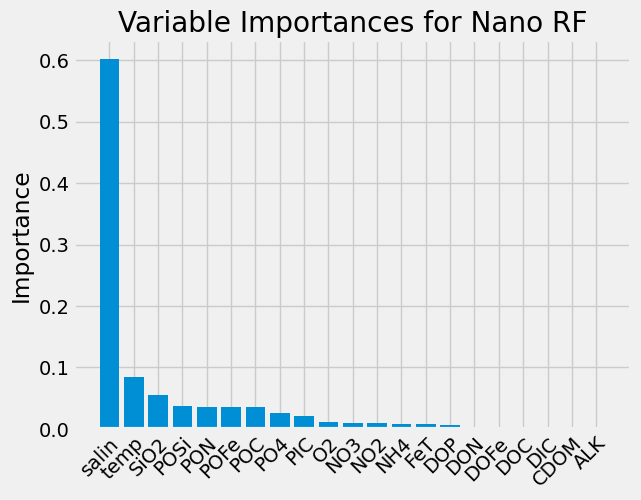

In [30]:
feature_importance = pd.DataFrame(rf.feature_importances_, index=feature_list).sort_values(by=0, ascending=False)

# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# Make a bar chart
plt.bar(x=feature_importance.index,height=feature_importance[0], orientation = 'vertical')
# Tick labels for x axis
plt.xticks(feature_importance.index, feature_list, rotation=45, ha='right', rotation_mode='anchor')

# Axis labels and title
plt.ylabel('Importance'); plt.title('Variable Importances for Nano RF');

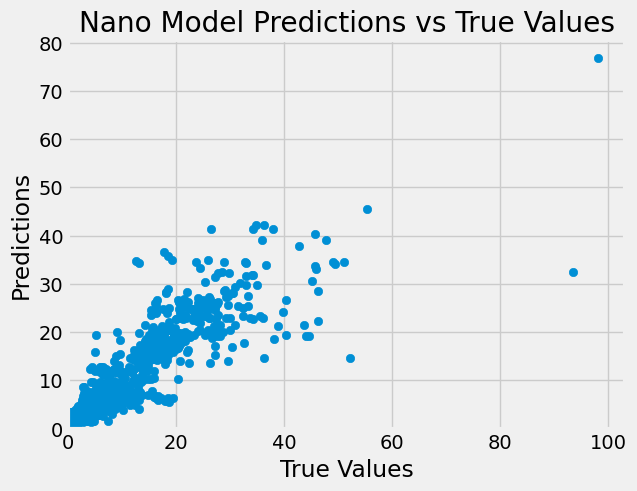

In [31]:
fig, ax = plt.subplots()
ax.scatter(test_labels, predictions)
ax.set_title('Nano Model Predictions vs True Values')
ax.set_ylim(ymin=0)
ax.set_xlim(xmin=0)

ax.set_xlabel('True Values')
ax.set_ylabel('Predictions')

plt.show()

# run the model on each individual populaton - see which does best
#put zero values when 